In [1]:
import mitsuba as mi

mi.set_variant("cuda_ad_rgb")
import drjit as dr
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

import os
import sys
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from utils.rough_scene import (
    ENVLIGHT_KEY,
    ROUGH_KEY,
    Scene,
    generate_rand_envlight,
    generate_rand_init_values,
    generate_rand_rough_tex,
    plot_rough_envlight,
    plot_rough_envlight2,
    reset_scene,
    reset_func,
    get_full_zeros_params,
    get_full_ones_params,
    run_opt_set_init,
    plot_opt_results,
    upsample,
)
from utils.utils import image_to_bm, to_float, unidim_to_bm, rel_l1_loss, mse, LOSS_FNS
from utils.plot import (
    plot_loss_linear_interp_1d,
    plot_loss_bilinear_interp_2d,
    plot_losses,
)

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)

In [2]:
def plot(
    images_bm, tex_bm, size_factor=3
):
    fig, ax = plt.subplots(
        ncols=2,
        nrows=len(images_bm),
        figsize=(8, size_factor * len(images_bm)),
        squeeze=False,
    )
    for i, (img, tex) in enumerate(
        zip(images_bm, tex_bm)
    ):
        ax[i, 0].imshow(img, vmin=0, vmax=1)
        ax[i, 1].imshow(tex, vmin=0, vmax=1)
        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 1].set_xticks([])
        ax[i, 1].set_yticks([])
    ax[0, 0].set_title("Rendering", weight="bold", size=14)
    ax[0, 1].set_title("Roughness texture", weight="bold", size=14)
    plt.tight_layout()
    plt.show()

In [3]:
CAMERA_ROT = [
    {"axis":[1, 0, 0], "angle":0},
    {"axis":[1, 0, 0], "angle":30},
    {"axis":[1, 0, 0], "angle":-30},
    {"axis":[0, 1, 0], "angle":30},
    {"axis":[0, 1, 0], "angle":-30},
    {"axis":[0, 0, 1], "angle":30},
    {"axis":[0, 0, 1], "angle":-30},
]

# Reference scenes rendering

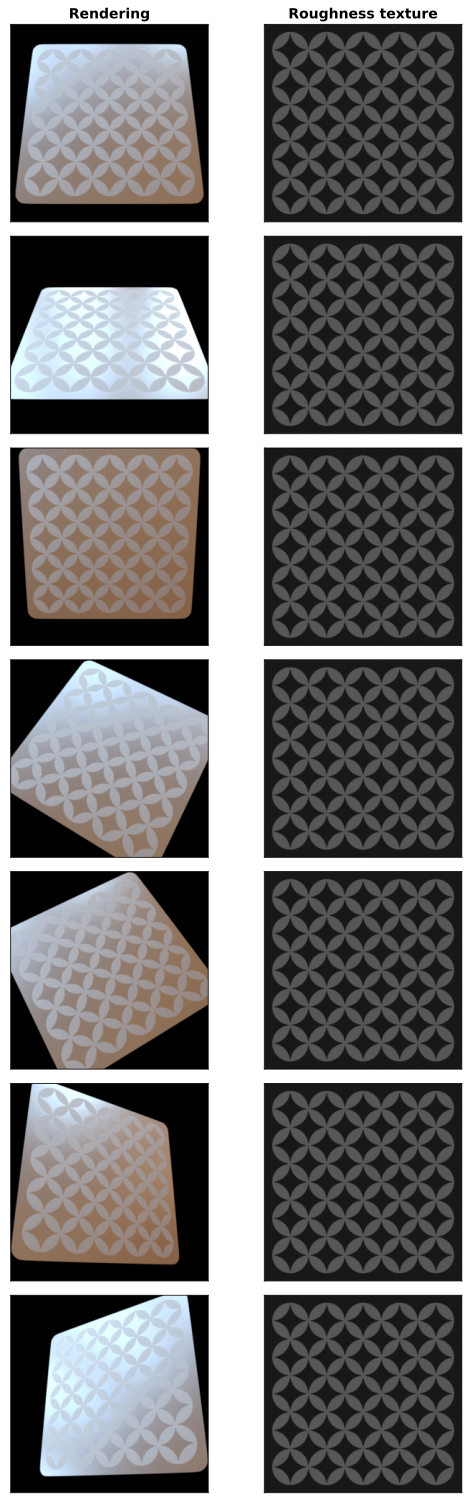

In [4]:
spp_ref = 1024

scene = reset_scene(Scene.COND1)
params_ref = mi.traverse(scene)

params_roughtex_ref = params_ref[ROUGH_KEY]
params_roughtex_ref_bm = unidim_to_bm(params_roughtex_ref)

image_ref = []
image_ref_bm = []

# Render reference images
for i, rot in enumerate(CAMERA_ROT):
    scene = reset_scene(Scene.COND1)
    params = mi.traverse(scene)
    params['PerspectiveCamera.to_world'] = mi.Transform4f.rotate(**rot) @ params['PerspectiveCamera.to_world']
    image_ref.append(mi.render(scene, seed=i, spp=spp_ref))
    image_ref_bm.append(image_to_bm(image_ref[i]))

# Plot
plot(image_ref_bm, [params_roughtex_ref_bm] * len(image_ref_bm))

In [5]:
spp_primal = 32
spp = spp_primal
spp_grad = 4

{'Relative L1': 0.34395143762230873, 'MSE': 0.012799236399587244}


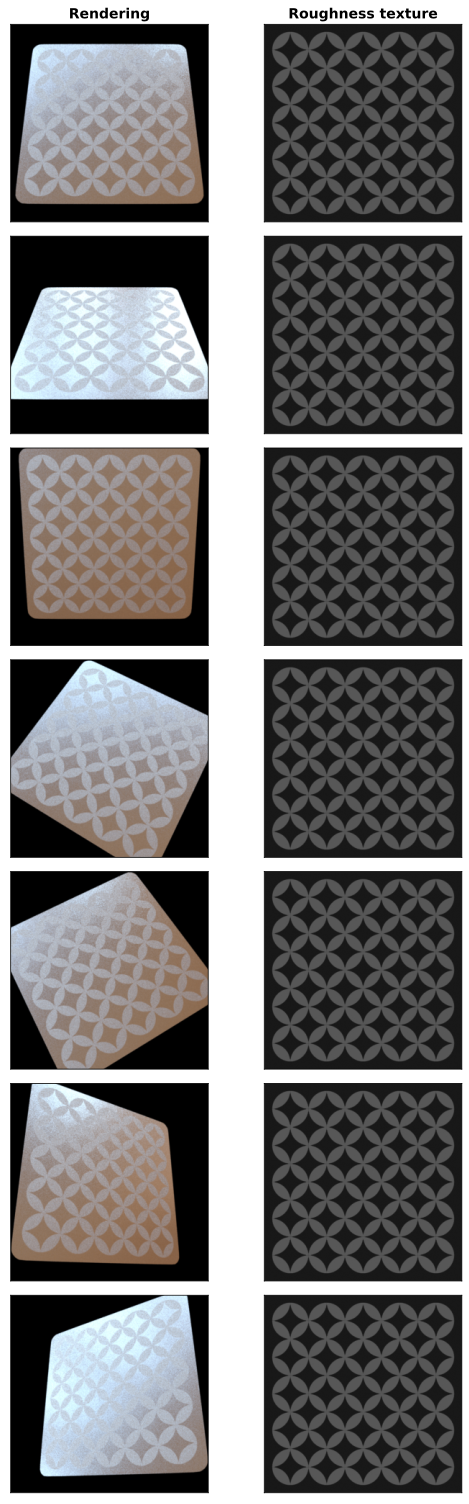

In [6]:
# get reference losses
ref_loss = {k: 0.0 for k in LOSS_FNS}
images = []
for i, rot in enumerate(CAMERA_ROT):
    scene = reset_scene(Scene.COND1)
    params = mi.traverse(scene)
    params['PerspectiveCamera.to_world'] = mi.Transform4f.rotate(**rot) @ params['PerspectiveCamera.to_world']
    image = mi.render(scene, mi.traverse(scene), seed=i, spp=spp_primal)
    images.append(image)
    for k in LOSS_FNS:
        ref_loss[k] += to_float(LOSS_FNS[k](image, image_ref[i]))
print(ref_loss)
plot([image_to_bm(image) for image in images], [params_roughtex_ref_bm] * len(images))

In [7]:
def run_opt_set_init(
    scene_name: Scene,
    init_values,
    optimizer_name="adam",
    lr=1e-2,
    loss_fn=mse,
    n_iterations=10,
    spp_primal=16,
    spp_grad=4,
):
    # Optimization parameters
    optimizer_name = optimizer_name.lower().strip()

    losses = []
    images_init = []
    images_bm_init = []
    images_end = []
    images_bm_end = []
    tex_bm_init = []
    tex_bm_end = []
    params_end = []

    nb_opt_samples = len(init_values)

    for (opt_sample, initial_values) in enumerate(init_values):
        scene = reset_scene(Scene.COND1)
        params = mi.traverse(scene)
        params[ROUGH_KEY] = initial_values
        params.update()

        if optimizer_name == "sgd":
            opt = mi.ad.optimizers.SGD(lr=lr)
        elif optimizer_name == "adam":
            opt = mi.ad.optimizers.Adam(lr=lr)
        else:
            raise ValueError(f"Unknown optimizer {optimizer_name}")

        opt[ROUGH_KEY] = params[ROUGH_KEY]
        params.update(opt)

        losses.append([])
        for it in range(1,n_iterations+1):
            total_loss = 0.0
            for i, rot in enumerate(CAMERA_ROT):
                params['PerspectiveCamera.to_world'] = mi.Transform4f.rotate(**rot) @ params_ref['PerspectiveCamera.to_world']
                params.update()

                image = mi.render(
                    scene,
                    params,
                    seed=opt_sample * n_iterations + it + i * nb_opt_samples * n_iterations,
                    spp=spp_primal,
                    spp_grad=spp_grad,
                )

                if it == 1:
                    if i == 0:
                        images_init.append([])
                        images_bm_init.append([])
                        tex_bm_init.append(unidim_to_bm(params[ROUGH_KEY]))
                    images_init[opt_sample].append(image)
                    images_bm_init[opt_sample].append(image_to_bm(image))
                
                # Compute loss
                loss = loss_fn(image, image_ref[i])
                total_loss += to_float(loss)

                # Backpropagate
                dr.backward(loss)

                # Optimizer: take a gradient step
                opt.step()
                opt[ROUGH_KEY] = dr.clamp(opt[ROUGH_KEY], 1e-2, 1.0)

                # Optimizer: Update the scene parameters
                params.update(opt)

                if it == n_iterations:
                    if i == 0:
                        images_end.append([])
                        images_bm_end.append([])
                    images_end[opt_sample].append(image)
                    images_bm_end[opt_sample].append(image_to_bm(image))
                    if i == len(CAMERA_ROT) - 1:
                        tex_bm_end.append(unidim_to_bm(params[ROUGH_KEY]))
                        params_end.append(params[ROUGH_KEY])

            print(
                f"[Sample {opt_sample+1}/{nb_opt_samples}]  Iteration {it:03d}: loss={total_loss:.5f}",
                end="\r",
            )
            losses[opt_sample].append(total_loss)
        print()
        
    return {
        "losses": losses,
        "images_init": images_init,
        "images_bm_init": images_bm_init,
        "images_end": images_end,
        "images_bm_end": images_bm_end,
        "tex_bm_init": tex_bm_init,
        "tex_bm_end": tex_bm_end,
        "params_end": params_end,
    }


# Run optimization

In [38]:
values = [generate_rand_rough_tex(Scene.COND1, seed=i) for i in range(1)]
res = run_opt_set_init(Scene.COND1, values, optimizer_name="adam", lr=2e-3, loss_fn=mse, n_iterations=300, spp_primal=spp_primal, spp_grad=spp_grad)

[Sample 1/1]  Iteration 300: loss=0.01324


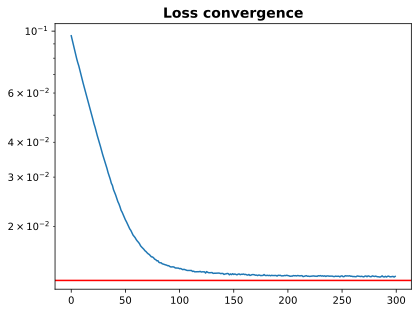

In [39]:
plot_losses(res["losses"], baseline=ref_loss["MSE"])

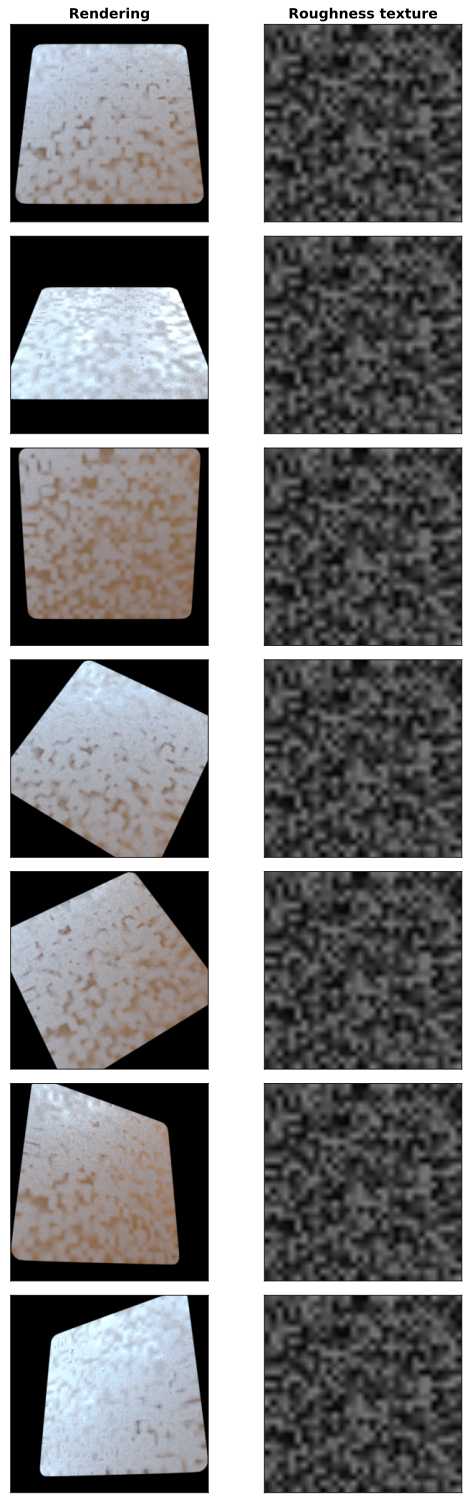

In [40]:
plot(res["images_bm_init"][0], res["tex_bm_init"]*len(res["images_bm_init"][0]), size_factor=3)

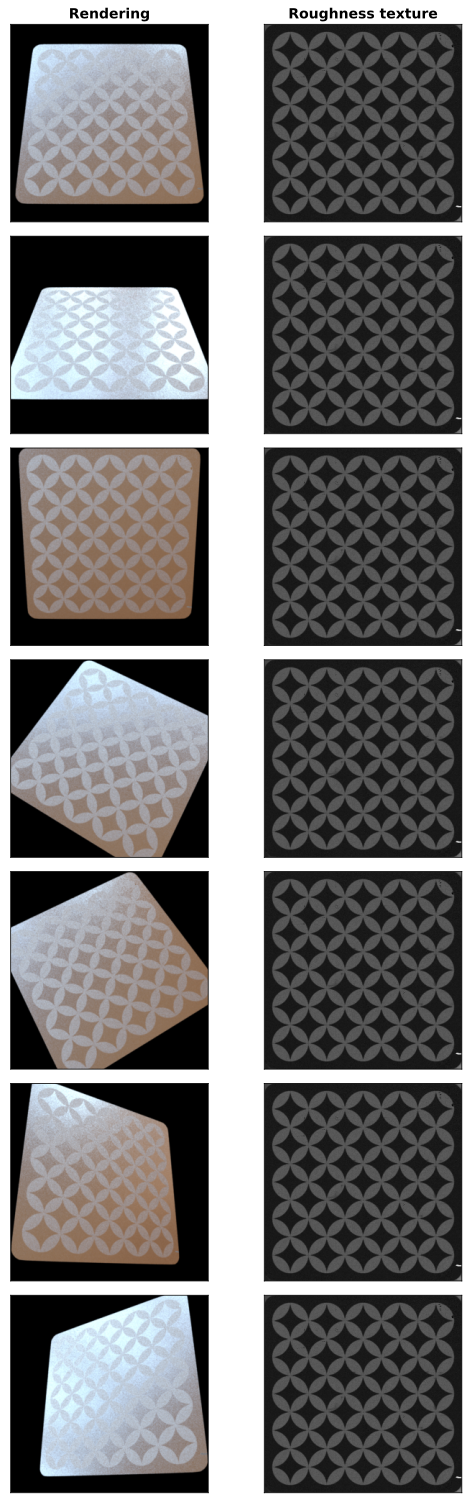

In [41]:
plot(res["images_bm_end"][0], res["tex_bm_end"]*len(res["images_bm_end"][0]), size_factor=3)

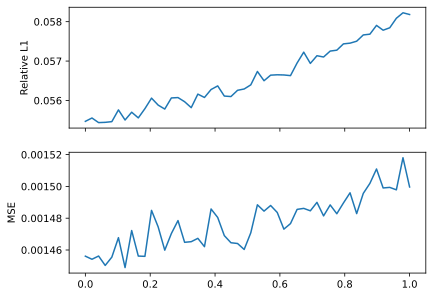

In [42]:
params_1 = {ROUGH_KEY: params_roughtex_ref}
params_2 = {ROUGH_KEY: res["params_end"][0]}
plot_loss_linear_interp_1d(image_ref[0], params_1, params_2, reset_scene_func=lambda: reset_scene(Scene.COND1))